In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile

import os
os.add_dll_directory("C://Users/amirs/anaconda3/DLLs")

from datasets import Dataset

# from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.utils.data import Dataset, DataLoader
from imageio import imread
from glob import glob
import json

from PIL import Image

In [2]:
paths = glob("C:/Users/amirs/OneDrive - Imperial College London/UROP/Pytorch/DRIVE/training/*")

In [3]:
test_img = glob(paths[0] + "/*")[1] 
test_img

'C:/Users/amirs/OneDrive - Imperial College London/UROP/Pytorch/DRIVE/training\\1st_manual\\22_manual1.gif'

In [4]:
img1 = imread(test_img)
type(img1)

C:\Users\amirs\AppData\Local\Temp\ipykernel_19636\2840112751.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imread(test_img)


imageio.core.util.Array

In [5]:

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [6]:
class Drive(Dataset):
    def __init__(self, paths, transform=None, target_transform=None):
        self.img_dir = paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(glob(self.img_dir[1] + "/*"))
    

    def __getitem__(self, idx):
        #There is only one image in each images path. So we will grab the "first" thing we find with "[0]" at the end
        img_path = glob(self.img_dir[1] + "/*")[idx]        
        #but there are multiple mask images in each mask path
        mask_imgs = glob(self.img_dir[0] + "/*")[idx]             
        #the image shape is (W, H, 4), the last dimension is an 'alpha' channel that is not used
        img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
        #Now we want this as (3, W, H), which is the normal shape for PyTorch
        # img = np.array(img)
        # img = np.moveaxis(img, -1, 0)
        #Last step for the image, re-scale it to the range [0, 1]
        # img = img/255.0
        
        if self.transform:
            # img = torch.FloatTensor(img)
            # state = torch.get_rng_state()
            # img = self.transform(img)
            # torch.set_rng_state(state)

            img =img
        else:    
            image = Image.fromarray(img.astype(np.uint8))
            # img = torch.FloatTensor(img)
       
        #Every mask image is going to have a shape of (W, H) which has a value of 1 if the pixel is of a nuclei, and a value of 0 if the image is background/ a  _different_ nuclei
        masks  = imread(mask_imgs)
#         masks = [imread(f)/255.0 for f in mask_imgs]
        if self.target_transform:
#             masks = torch.FloatTensor(masks)
            
#             masks = masks.unsqueeze(0)
#             masks = self.target_transform(masks)
             masks = masks
           
        else:
            # final_mask = np.zeros(masks.shape)
            # final_mask = np.logical_or(final_mask, masks)
            # masks = torch.Tensor(masks)
            # masks =  F.one_hot(masks.to(torch.int64), 2).permute(2,0,1)
            masks =  Image.fromarray(masks.astype(np.uint8))

        
        
        #Not every image in the dataset is the same size.  To simplify the problem, we are going to re-size  every image to be (256, 256)
        # img, final_mask = torch.tensor(img), torch.tensor(final_mask).unsqueeze(0) #First we convert to PyTorch tensors
        #The interpolate function can be used to re-size a batch of images. So we make each image a "batch" of 1
        # image = F.interpolate(img.unsqueeze(0), (256,256))
        # label = F.interpolate(masks.to(torch.float).unsqueeze(0), (256,256))
        # Now the shapes  are (B=1, C, W, H) We need to convert them back to FloatTensors and grab the first item in the "batch". This will return a tuple of: (3, 256, 256), (1, 256, 256)
        return image, masks
        # return img, masks

In [7]:
class SAMDataset(Dataset):
    
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item[0]
        ground_truth_mask = np.array(item[1])

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [8]:
data = Drive(paths)

In [9]:
len(data)

20

C:\Users\amirs\AppData\Local\Temp\ipykernel_19636\4223705831.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
C:\Users\amirs\AppData\Local\Temp\ipykernel_19636\4223705831.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks  = imread(mask_imgs)


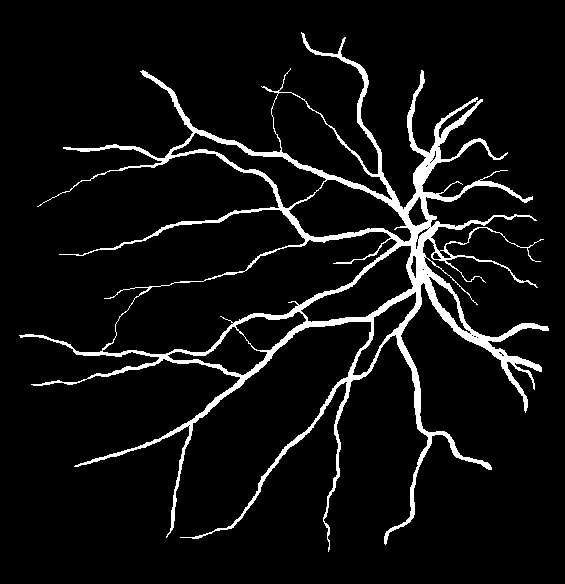

In [10]:
data[2][1]

In [17]:
prompt = get_bounding_box(np.array(data[2][1]))
# plt.imshow(prompt)
prompt

C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks  = imread(mask_imgs)


[6, 24, 556, 569]

In [18]:
plt.imshow(data[2][0].permute(1,2,0).numpy(), cmap ='gray')

C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks  = imread(mask_imgs)


AttributeError: 'Image' object has no attribute 'permute'

In [19]:

from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [20]:


train_dataset = SAMDataset(dataset=data, processor=processor)
     


In [21]:

example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)
     

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (584, 565)


C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks  = imread(mask_imgs)


In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [23]:


batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)
     


C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks  = imread(mask_imgs)


pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 584, 565])


In [24]:


from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
     


In [28]:


from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
     


In [29]:


from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        
        predicted_masks = nn.functional.interpolate(predicted_masks,
                        size=(584, 565),
                        mode='bilinear',
                align_corners=False)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

              # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

              # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
     


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks  = imread(mask_imgs)
100%|██████████| 10/10 [01:37<00:00,  9.77s/it]


EPOCH: 0
Mean loss: -80.6782344341278


100%|██████████| 10/10 [01:09<00:00,  6.96s/it]


EPOCH: 1
Mean loss: -199.14083862304688


100%|██████████| 10/10 [01:06<00:00,  6.68s/it]


EPOCH: 2
Mean loss: -408.9168304443359


100%|██████████| 10/10 [01:06<00:00,  6.65s/it]


EPOCH: 3
Mean loss: -1121.4036376953125


100%|██████████| 10/10 [01:04<00:00,  6.48s/it]


EPOCH: 4
Mean loss: -2731.19658203125


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 5
Mean loss: -5899.180859375


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 6
Mean loss: -11227.033349609375


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 7
Mean loss: -18021.12666015625


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 8
Mean loss: -24639.115234375


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 9
Mean loss: -31255.70703125


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 10
Mean loss: -37607.1625


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 11
Mean loss: -43951.083203125


100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


EPOCH: 12
Mean loss: -50265.52265625


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 13
Mean loss: -56570.7859375


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 14
Mean loss: -62904.21484375


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 15
Mean loss: -68939.825


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


EPOCH: 16
Mean loss: -74711.5625


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 17
Mean loss: -80461.658203125


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 18
Mean loss: -86217.01015625


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 19
Mean loss: -91492.00390625


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 20
Mean loss: -97044.90078125


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 21
Mean loss: -102388.4703125


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 22
Mean loss: -107632.82890625


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 23
Mean loss: -113103.87734375


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 24
Mean loss: -118326.68125


100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


EPOCH: 25
Mean loss: -123687.9859375


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 26
Mean loss: -128892.39765625


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 27
Mean loss: -134104.00625


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 28
Mean loss: -139578.73046875


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 29
Mean loss: -144950.2625


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 30
Mean loss: -150340.696875


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 31
Mean loss: -155769.69296875


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 32
Mean loss: -161189.40078125


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 33
Mean loss: -166797.165625


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 34
Mean loss: -172356.7890625


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 35
Mean loss: -177895.984375


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 36
Mean loss: -183615.0890625


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 37
Mean loss: -189483.053125


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 38
Mean loss: -195300.7265625


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 39
Mean loss: -201067.9046875


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 40
Mean loss: -207007.903125


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 41
Mean loss: -213177.10625


100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


EPOCH: 42
Mean loss: -219368.284375


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 43
Mean loss: -225660.996875


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 44
Mean loss: -231885.8328125


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 45
Mean loss: -238491.8046875


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 46
Mean loss: -245003.434375


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 47
Mean loss: -251502.4671875


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 48
Mean loss: -258474.5078125


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 49
Mean loss: -265112.2515625


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 50
Mean loss: -272161.0234375


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 51
Mean loss: -279366.2109375


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 52
Mean loss: -286412.690625


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 53
Mean loss: -293721.25625


100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


EPOCH: 54
Mean loss: -301042.915625


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 55
Mean loss: -308592.234375


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 56
Mean loss: -316322.315625


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 57
Mean loss: -324054.7125


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 58
Mean loss: -331871.146875


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 59
Mean loss: -339814.440625


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 60
Mean loss: -347828.0375


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 61
Mean loss: -356087.628125


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 62
Mean loss: -364600.38125


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 63
Mean loss: -372938.678125


100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


EPOCH: 64
Mean loss: -381651.978125


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 65
Mean loss: -390329.4625


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 66
Mean loss: -399130.55


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 67
Mean loss: -408074.125


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 68
Mean loss: -417366.328125


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 69
Mean loss: -426603.975


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 70
Mean loss: -436183.0625


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 71
Mean loss: -445856.096875


100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


EPOCH: 72
Mean loss: -455424.175


100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


EPOCH: 73
Mean loss: -465292.93125


100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


EPOCH: 74
Mean loss: -475563.115625


 30%|███       | 3/10 [00:24<00:56,  8.03s/it]


KeyboardInterrupt: 

In [30]:
testData = data[1][0]
test

# plt.imshow(testData.permute(1,2,0).numpy(), cmap ='gray')

C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks  = imread(mask_imgs)


In [31]:


# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(data[19][1])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(testData, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)
     


pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
C:\Users\amirs\AppData\Local\Temp\ipykernel_16820\4223705831.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks  = imread(mask_imgs)


In [32]:
model.eval()
with torch.no_grad(): #We don't want gradients if we aren't training, so no gradients please!
    #push a test datapoint through the model. Remember the raw outputs are called the logits
    outputs = model(**inputs, multimask_output=False)

In [33]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.9).astype(np.uint8)

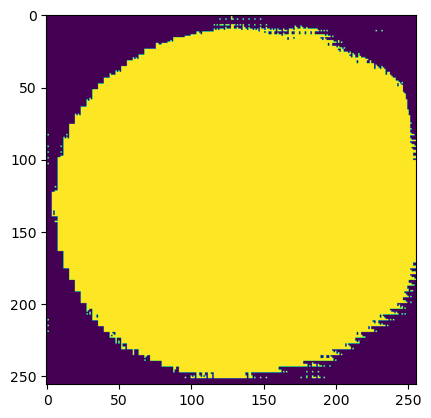

In [34]:
plt.imshow(medsam_seg)

(-0.5, 255.5, 255.5, -0.5)

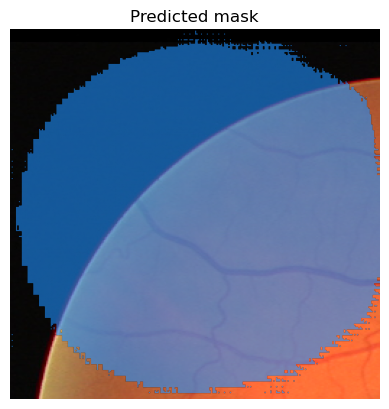

In [40]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(testData, cmap ='gray')
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")
     

In [41]:
torch.save(model.state_dict(), "C://Users/amirs/OneDrive - Imperial College London/Year 3/Y3 Group Project/SAM Model/SAMmodel/sam2.pth")